# Iron analysis

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *
from bacillusme.analysis import sensitivity as ss


import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [2]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')
ibsu_directory = join(flat_files.ecoli_files_dir, 'iBsu1103.json') 

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)
ibsu = cobra.io.load_json_model(ibsu_directory)

bsub.optimize()

<Solution 0.12 at 0x7f0372c28278>

In [3]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [4]:
fe_uptake = me.solution.x_dict['EX_4fe4s_e']

In [7]:
uptake_rates={}
for i in np.arange(0,11):
    met_id = '4fe4s_{}'.format(str(i))
    uptake_rates[met_id] = fe_uptake*i*10

In [8]:
flux_response_me = ss.all_flux_responses(me,list(uptake_rates.keys()),mu_fix=False,solution=0,NP=12,precision=1e-6,
                       single_change_function='feed_metabolite',growth_key = 'mu',sequential=False,met_flux_dict=uptake_rates)


biomass_dilution response (11 threads): 100%|██████████| 11/11 [24:09<00:00, 280.35s/it]

In [14]:
flux_response_me = flux_response_me[list(uptake_rates.keys())].drop('base',axis=1)
flux_response_me = flux_response_me.drop('4fe4s_0',axis=1)

,4fe4s_0,4fe4s_1,4fe4s_2,4fe4s_3,4fe4s_4,4fe4s_5,4fe4s_6,4fe4s_7,4fe4s_8,4fe4s_9,4fe4s_10
biomass_dilution,0.0,0.101704,0.101693,0.101682,0.101671,0.101659,0.101649,0.101637,0.101627,0.101615,0.101604
protein_biomass_to_biomass,0.0,0.035772,0.035767,0.035763,0.035758,0.035753,0.035749,0.035744,0.035740,0.035735,0.035730
mRNA_biomass_to_biomass,0.0,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118
tRNA_biomass_to_biomass,0.0,0.000718,0.000718,0.000718,0.000718,0.000718,0.000718,0.000719,0.000719,0.000719,0.000719
rRNA_biomass_to_biomass,0.0,0.005196,0.005196,0.005197,0.005197,0.005198,0.005198,0.005198,0.005199,0.005199,0.005199
...,...,...,...,...,...,...,...,...,...,...,...
translocation_BSU39410,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
translocation_BSU39450,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
translocation_BSU39710,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
translocation_BSU40070,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


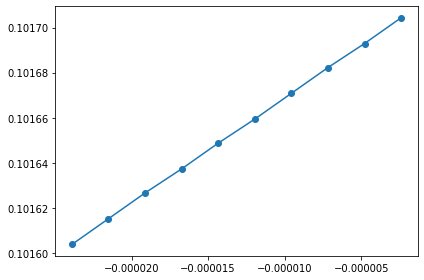

In [29]:
plt.plot(flux_response_me.loc['EX_4fe4s_e'],flux_response_me.loc['biomass_dilution'],'-o')
plt.tight_layout()

In [22]:
met_list = [m.id for m in me.metabolites if '__L_c' in m.id and isinstance(m,cobrame.Metabolite) and len(m.id)==8]
[met_list.append(m) for m in ['gly_c','chor_c']]

[None, None]

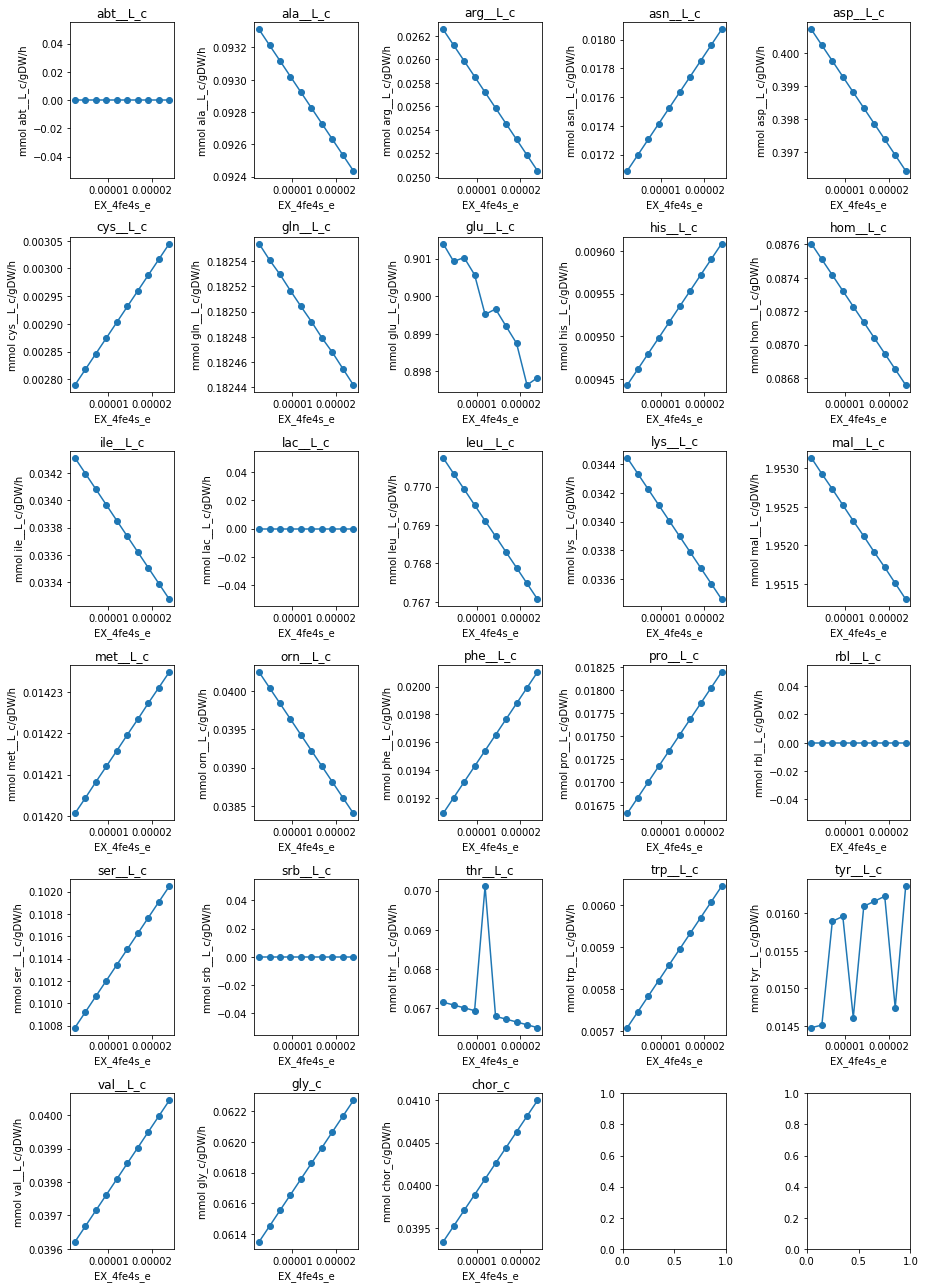

In [39]:
fig,ax = plt.subplots(int(np.ceil(np.sqrt(len(met_list)))),int(np.floor(np.sqrt(len(met_list)))),figsize=(13,3*int(np.ceil(np.sqrt(len(met_list))))))
ax = ax.flatten()
temp_dict = {}
for idx,met_id in enumerate(met_list):
    temp_dict[met_id] = {}
    met_rate = []
    uptake_rate = []
    for idx2,case in enumerate(flux_response_me.columns):
        df = flux_based_reactions(me,met_id,flux_dict=flux_response_me[case].to_dict(),only_types=['MetabolicReaction'])
        met_rate.append(df[df.met_flux>0]['met_flux'].sum())
        uptake_rate.append(-flux_response_me[case]['EX_4fe4s_e'])
        temp_dict[met_id][idx2] = met_rate[-1]
    ax[idx].plot(uptake_rate,met_rate,'-o')
    ax[idx].set_xlabel('EX_4fe4s_e')
    ax[idx].set_ylabel('mmol {}/gDW/h'.format(met_id))
    ax[idx].set_title(met_id)
fig.tight_layout()
fig.savefig('figures/iron_analysis.svg',format='SVG')

In [49]:
pd.DataFrame.from_dict(temp_dict).T.to_csv('iron_compounds_production.csv')

In [48]:
flux_response_me.to_csv('iron_all_fluxes.csv')

0.00944309422528549 2.3903954917238217e-06
0.009461426544685701 4.780790983447643e-06
0.009479839117631103 7.171186475171465e-06
0.009498171496788511 9.561581966895287e-06
0.009516532625877379 1.1951977458619109e-05
0.009534916564335158 1.434237295034293e-05
0.009553249034190081 1.6732768442066752e-05
0.00957166174733266 1.9123163933790574e-05
0.009589994276953787 2.1513559425514395e-05
0.009608326837514423 2.3903954917238217e-05


Text(0.5, 1.0, 'his__L_c')

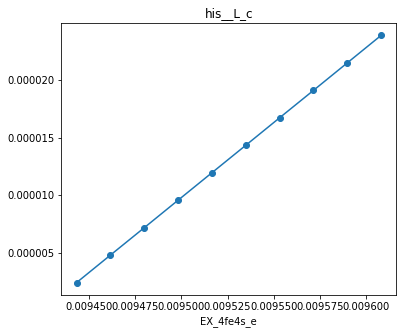

In [24]:
met_id = 'his__L_c'

met_rate = []
uptake_rate = []
for case in flux_response_me.columns:
    df = flux_based_reactions(me,met_id,flux_dict=flux_response_me[case].to_dict(),only_types=['MetabolicReaction'])
    met_rate.append(df[df.met_flux>0]['met_flux'].sum())
    uptake_rate.append(-flux_response_me[case]['EX_4fe4s_e'])
    print(met_rate[-1],uptake_rate[-1])
    
fig = plt.figure(figsize=(6,5))
plt.plot(met_rate,uptake_rate,'-o')
plt.xlabel('EX_4fe4s_e')
plt.title(met_id)

In [ ]:
flux_based_reactions(me,'chor_c',flux_dict=flux_response_me['4fe4s_2'].to_dict())

In [ ]:
np.ceil(np.sqrt(10))